In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Load Dataset

In [2]:
data = pd.read_csv('subscription.csv')
data = data.drop(labels='subscription_signup_date', axis=1)
data.head()

,user_id,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,29,Spain,ads,4,0
1,12474,49,France,ads,5,0
2,12294,49,Germany,ads,2,0
3,3878,49,China,ads,1,0
4,9567,49,UK,ads,5,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
user_id                      500000 non-null int64
subscription_monthly_cost    500000 non-null int64
country                      500000 non-null object
source                       500000 non-null object
billing_cycles               500000 non-null int64
is_active                    500000 non-null int64
dtypes: int64(4), object(2)
memory usage: 22.9+ MB


# Question 1

In [4]:
def retention_rate(df):
    total_num = len(df)
    rate = []
    for i in [1, 2, 3, 4, 5, 6, 7, 8]:
        rate.append(len(df[df['billing_cycles'] >= i]) / total_num)
        
    return pd.Series(rate, index=[1, 2, 3, 4, 5, 6, 7, 8])

# calculate the retention rate for each montly cost
grouped = data.groupby('subscription_monthly_cost').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
subscription_monthly_cost,,,,,,,,
29,1.0,0.607542,0.458473,0.376232,0.323028,0.285416,0.257157,0.235901
49,1.0,0.383666,0.206247,0.134043,0.096466,0.074072,0.059408,0.048845
99,1.0,0.158769,0.070040,0.042411,0.029676,0.022182,0.017937,0.015007


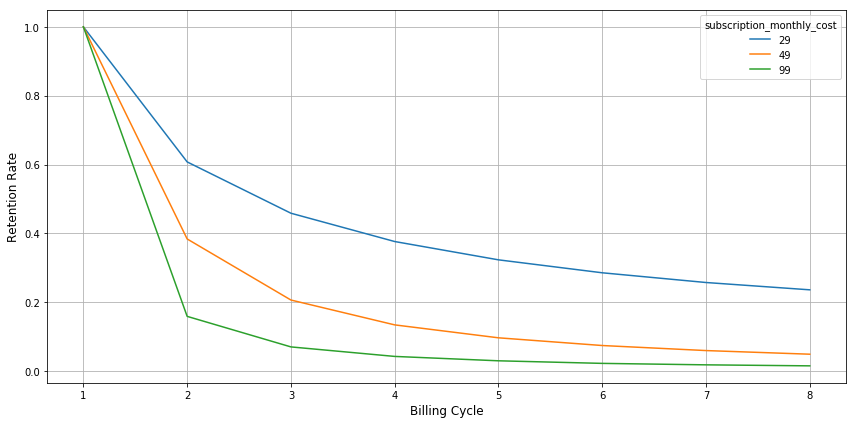

In [5]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
grouped.T.plot(kind='line', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

Now, let's add some non-linear component. For features, we add $x$, $x^2$, and $log(x)$ as the feature. For the target, we fit $log(rate)$ instead. 

Reference resource: [Online link](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/19.SubscribeRetention/subscribe_retention.ipynb)

In [6]:
# Let's create features
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
x2 = x ** 2
logx = np.log(x)
rate_29 = grouped.loc[29].values
rate_49 = grouped.loc[49].values
rate_99 = grouped.loc[99].values

features = pd.DataFrame({'x': x, 'x2': x2, 'logx': logx, 'y_29': rate_29, 'y_49': rate_49, 'y_99': rate_99}, 
                        columns=['x', 'x2', 'logx', 'y_29', 'y_49', 'y_99'])
features

,x,x2,logx,y_29,y_49,y_99
0,1,1,0.000000,1.000000,1.000000,1.000000
1,2,4,0.693147,0.607542,0.383666,0.158769
2,3,9,1.098612,0.458473,0.206247,0.070040
3,4,16,1.386294,0.376232,0.134043,0.042411
4,5,25,1.609438,0.323028,0.096466,0.029676
5,6,36,1.791759,0.285416,0.074072,0.022182
6,7,49,1.945910,0.257157,0.059408,0.017937
7,8,64,2.079442,0.235901,0.048845,0.015007


In [7]:
# Fit linear regression model
model_29 = LinearRegression()
model_49 = LinearRegression()
model_99 = LinearRegression()

model_29 = model_29.fit(features[['x', 'x2', 'logx']], np.log(features['y_29']))
model_49 = model_49.fit(features[['x', 'x2', 'logx']], np.log(features['y_49']))
model_99 = model_99.fit(features[['x', 'x2', 'logx']], np.log(features['y_99']))

# Question 2

In [8]:
# make prediction
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
x2 = x ** 2
logx = np.log(x)

pred = pd.DataFrame({'x': x, 'x2': x2, 'logx': logx}, columns=['x', 'x2', 'logx'])
pred['pred_29'] = np.exp(model_29.predict(pred[['x', 'x2', 'logx']]))
pred['pred_49'] = np.exp(model_49.predict(pred[['x', 'x2', 'logx']]))
pred['pred_99'] = np.exp(model_99.predict(pred[['x', 'x2', 'logx']]))

pred

,x,x2,logx,pred_29,pred_49,pred_99
0,1,1,0.000000,0.999502,1.003844,0.992027
1,2,4,0.693147,0.608619,0.378064,0.163419
2,3,9,1.098612,0.458101,0.208259,0.069098
3,4,16,1.386294,0.375765,0.135129,0.041513
4,5,25,1.609438,0.322898,0.096500,0.029441
5,6,36,1.791759,0.285608,0.073590,0.022695
6,7,49,1.945910,0.257606,0.058968,0.018197
7,8,64,2.079442,0.235610,0.049174,0.014781
8,9,81,2.197225,0.217726,0.042412,0.011960
9,10,100,2.302585,0.202786,0.037674,0.009529


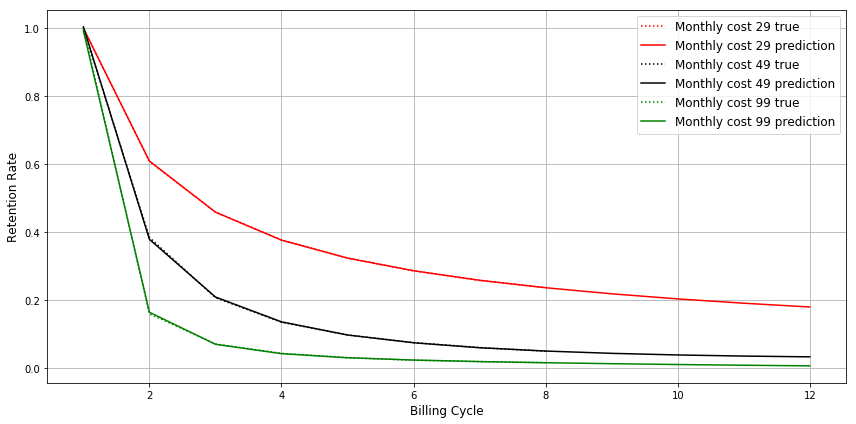

In [9]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(features['x'], features['y_29'], 'r:', label='Monthly cost 29 true')
ax.plot(pred['x'], pred['pred_29'], 'r-', label='Monthly cost 29 prediction')
ax.plot(features['x'], features['y_49'], 'k:', label='Monthly cost 49 true')
ax.plot(pred['x'], pred['pred_49'], 'k-', label='Monthly cost 49 prediction')
ax.plot(features['x'], features['y_99'], 'g:', label='Monthly cost 99 true')
ax.plot(pred['x'], pred['pred_99'], 'g-', label='Monthly cost 99 prediction')
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

We can see that, our model works pretty good.

# Question 3

### 1. Influence of `Country`

In [10]:
# calculate the retention rate for each montly cost
grouped = data.groupby('country').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
country,,,,,,,,
China,1.0,0.514831,0.402777,0.360426,0.336274,0.319856,0.307084,0.295453
France,1.0,0.334946,0.177732,0.119004,0.088479,0.069935,0.058341,0.049688
Germany,1.0,0.451284,0.278411,0.195910,0.146474,0.115151,0.093868,0.078465
India,1.0,0.446728,0.326962,0.284527,0.261603,0.246736,0.234847,0.225769
Italy,1.0,0.341684,0.179502,0.119914,0.090015,0.071135,0.057523,0.048695
Spain,1.0,0.339098,0.178985,0.119879,0.088648,0.070065,0.057617,0.048503
UK,1.0,0.458938,0.285133,0.198067,0.149421,0.117356,0.095735,0.079494
US,1.0,0.456509,0.284255,0.198853,0.149284,0.117398,0.094875,0.078981


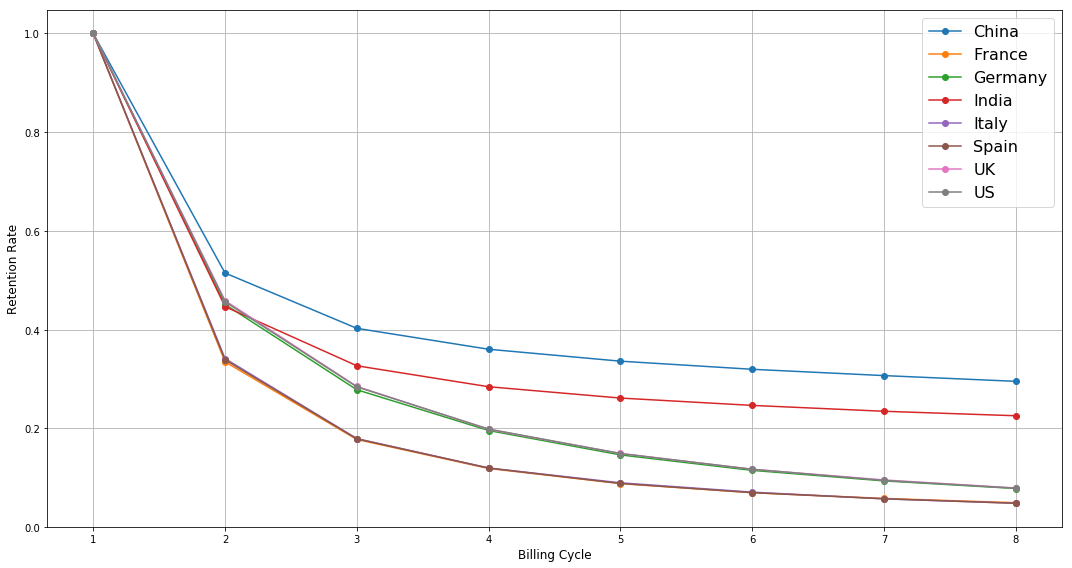

In [11]:
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
grouped.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

### 2. Influence of `Source`

In [12]:
# calculate the retention rate for each montly cost
grouped = data.groupby('source').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
source,,,,,,,,
ads,1.0,0.388873,0.222094,0.152607,0.114959,0.092043,0.076756,0.066237
friend_referral,1.0,0.699443,0.617038,0.561282,0.519854,0.487596,0.461110,0.436507
seo,1.0,0.562395,0.420012,0.337594,0.286254,0.247877,0.218680,0.194475


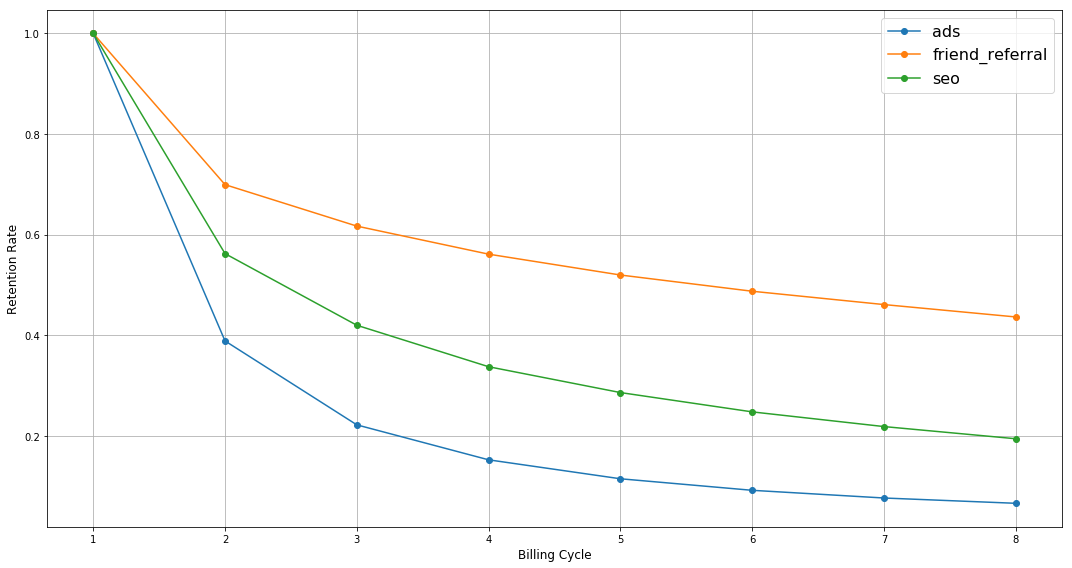

In [13]:
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
grouped.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

There exist some good analysis in [this notebook](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/19.SubscribeRetention/subscribe_retention.ipynb). Please refer to it for details.